## <b> Лабораторная работа 2 </b> <br>
## KAN и составные сплайны <br>
#### Зиберов Александр ИНС-м-о-25-1 <br>

#### <b> Цель работы: </b> Разработка и анализ алгоритма  для обучения нейронной сети KAN, состоящей из нескольких сплайнов (составных).

В прошлой работе ознакомились с понятием KAN и B-сплайнов, необходимых, для её построения. Перенесем функции для их использования далее.

In [ ]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions # функция из первой работы

**Задание.**  Реализация и оценка базисных функций

Необходимо оценить базисные функции для заданных входных данных и подобрать оптимальные коэффициенты для их линейной комбинации.

__Требования:__
<li> x_eval должна иметь размерность: количество образцов × количество измерений
<li> Сетка должна иметь размерность: количество функций активации × количество контрольных точек (рассматриваем только одну функцию активации)
<li> Выходные данные должны иметь размерность: количество образцов × количество измерений × количество базисных функций
<li> Коэффициенты должны иметь размерность: количество измерений × количество базисных функций

Строим базисы B-сплайна, как в предыдущей работе, а именно задаем степень сплайна k, создаём точки для его аппроксимации и контрольные точки (узлы), затем вычисляем значения базисных функций для каждой точки. Размер результата проверяем для уверенности, что всё корректно.

In [15]:
# Степень сплайна (управляет гладкостью и формой)
k = 2  

# Создаём 20 точек x от -1 до 1
x_eval = torch.linspace(-1, 1, steps=20).unsqueeze(dim=1)  

# Создаём сетку из 10 узлов (точек, где сплайн "ломается")
grid = torch.linspace(-1, 1, steps=10).unsqueeze(dim=0)  

# Вычисляем значения базисных функций B-сплайна для всех x и узлов
bases = eval_basis_functions(x_eval, grid, k)

# Проверяем размер полученного тензора
bases.shape

torch.Size([20, 1, 11])

Теперь мы возьмём некоторую сложную функцию и попытаемся оценить её с помощью линейной комбинации сплайнов.

Создаем функцию sin(pi*e^x), решаем задачу нахождения коэффициентов и вычисляем предсказания.

Входящие базисы: torch.Size([1, 20, 11])
Полученное значение Y: torch.Size([1, 20, 1])
Коэффициенты: torch.Size([1, 11, 1])


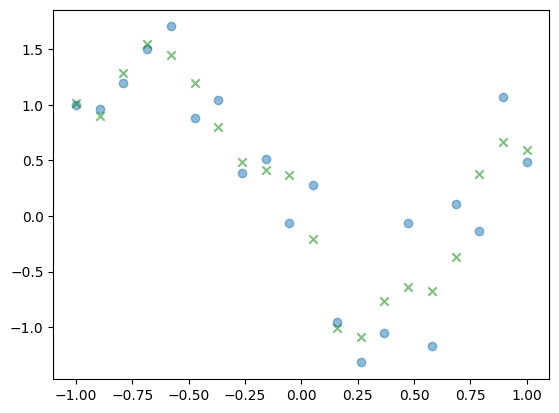

In [16]:
# Определим сложную целевую функцию
fn = lambda x: torch.sin(torch.pi * torch.exp(x))

# Вычисляем значения функции в точках x_eval и добавляем шум
y_eval = fn(x_eval) + torch.randn(x_eval.shape) * 0.4

# Решаем задачу наименьших квадратов — находим коэффициенты при базисах
coeff = torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution

# Вычисляем предсказания: умножаем базисы на найденные коэффициенты
y_pred = torch.einsum('ijk, bij->bk', coeff, bases)

# Рисуем исходные данные и аппроксимацию
plt.scatter(x_eval[:, 0], y_eval[:, 0], alpha=0.5)
plt.scatter(x_eval[:, 0], y_pred[:, 0], marker='x', color='green', alpha=0.5)

print(f"Входящие базисы: {bases.transpose(0, 1).shape}")
print(f"Полученное значение Y: {y_eval.unsqueeze(dim=0).shape}")
print(f"Коэффициенты: {coeff.shape}")

### **KAN и стекинг сплайнов**

<img src="images/kan-repr.png" width=750px></img>

KAN задаются как $[n_0, n_1, n_2, ..., n_l]$, где каждое число — количество измерений в соответствующем слое.  
Например:  
1. $[1, 1]$: 1 вход → 1 выход  
2. $[1, 1, 1]$: 1 вход → 1 нейрон скрытого слоя → 1 выход  
3. $[2, 1]$: 2 входа → 1 выход  

В KAN каждый нейрон формируется через **суммирование одномерных функций (B-сплайнов)**, вычисленных по выходам предыдущего слоя.  
Это следует из **теоремы Колмогорова–Арнольда**, которая утверждает, что любую функцию нескольких переменных можно разложить на сумму одномерных функций:  

$$
f(x, y, z) = \phi_1(x) + \phi_2(y) + \phi_3(z)
$$

То есть каждый нейрон KAN — это многомерная функция предыдущего слоя, сформированная сложением одномерных функций активации.  
Теорема доказана для сетей вида $[n, 2n+1, 1]$; для более глубоких KAN формальное обоснование пока отсутствует.  

Для сравнения, MLP умножает входы на веса, суммирует и применяет функцию активации для формирования нейрона.  

## Обратное распространение в KAN ([1, 1, 1])

Обратное распространение (backpropagation) — это алгоритм обучения нейронных сетей, который позволяет вычислять градиенты функции потерь по всем параметрам сети.

Рассмотрим сеть KAN вида [1, 1, 1] и как вычисляются градиенты коэффициентов.

1. **Выход первого слоя**:
$$
x' = \sum_{i=1}^{n} c_{0i} \cdot N_{0i}(x)
$$
где $c_{0i}$ — коэффициенты первого слоя, $N_{0i}(x)$ — значения B-сплайнового базиса для входа $x$.

2. **Прогноз сети**:
$$
\hat{y} = \sum_{i=1}^{n} c_{1i} \cdot N_{1i}(x')
$$
(линейная комбинация базисов второго слоя).

3. **Функция потерь** (L2-норма ошибки):
$$
\mathcal{L} = \|\hat{y} - y\|_2
$$

4. **Градиенты коэффициентов**:

- Для второго слоя:
$$
\frac{\partial \mathcal{L}}{\partial c_{1i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial c_{1i}}
$$

- Для первого слоя:
$$
\frac{\partial \mathcal{L}}{\partial c_{0i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial x'} \cdot \frac{\partial x'}{\partial c_{0i}}, 
\quad \text{где } \frac{\partial \hat{y}}{\partial x'} = \sum_{i=1}^{n} c_{1i} \cdot \frac{\partial N_{1i}(x')}{\partial x'}
$$

**Идея:** ошибка сети сначала вычисляется на выходе, а затем шаг за шагом передается назад к предыдущим слоям. При этом каждый нейрон обновляется пропорционально тому, как сильно его базисные функции (B-сплайны) влияют на ошибку. То есть это то же самое, что обычное обратное распространение в MLP, только вместо обычных весов используются одномерные сплайны.


### 1. Создание сети KAN [1, 1, 1]

Ниже напишем функцию для обучения стековой KAN с реализацией обратного распространения и ранней остановкой.

Функция single_stacked_kan_training реализует процесс обучения многослойной сети KAN, где каждый слой — это B-сплайн, аппроксимирующий нелинейную зависимость между входом и выходом.
На каждой итерации:
1) считается выход всех слоев поочередно (forward-pass);
2) вычисляется ошибка между предсказанием и целевым значением;
3) производится корректировка коэффициентов B-сплайнов с помощью градиентного спуска;
4) проверяется ошибка на тестовой выборке.
5) если долго нет улучшений при обучении — оно останавливается (early stopping).

На выходе функция возвращает:
<li> обученные параметры модели (веса и сетки сплайнов),
<li> последнее предсказание на тесте,
<li> историю ошибок (для построения графиков),
<li> промежуточные выходы каждого слоя (для анализа, визуализации).

In [17]:
def single_stacked_kan_training(
    x_training, y_training, x_test, y_test, 
    model_params=None, lr=0.1, k=2, n_layers=2, 
    grid_sizes=[], grid_ranges=[], 
    early_stopping_imrpovement_threshold=200, 
    early_stopping_iterations=1e4, 
    verbose=False, grid_range=[-1, 1], use_scales=False
):
    """
    Функция обучает каскадную (многоуровневую) модель KAN (Kolmogorov-Arnold Network)
    с количеством слоев, заданным параметром `n_layers`. 
    Каждый слой состоит из B-сплайнов, которые аппроксимируют функцию.
    
    Аргументы:
        x_training: входные данные для обучения (размер: количество_образцов × размерность_входа)
        y_training: целевые значения для обучения (размер: количество_образцов × 1)
        x_test: входные данные для проверки (валидации)
        y_test: целевые значения для проверки
        model_params: параметры уже обученной модели (если хотим продолжить обучение)
        lr: скорость обучения (learning rate)
        k: порядок сплайна
        n_layers: количество слоев в сети
        grid_sizes: количество контрольных точек для каждого слоя
        grid_ranges: диапазон узлов для каждого слоя
        early_stopping_improvement_threshold: через сколько итераций без улучшений остановить обучение
        early_stopping_iterations: максимальное количество итераций
        verbose: если True — выводить промежуточные ошибки
        grid_range: общий диапазон сетки (по умолчанию [-1, 1])
        use_scales: использовать ли масштабирование (из раздела 2 туториала)
    """

    # Если нет размера сеток, задаем одинаковые
    if grid_sizes == []:
        grid_sizes = [10] * n_layers

    # То же самое — для диапазонов сеток
    if grid_ranges == []:
        grid_ranges = [[-1, 1]] * n_layers

    # Если модель не была передана — создаем новую с нуля
    if not model_params:
        grids, coeffs, scale_bases, scale_splines, base_fns = [], [], [], [], []

        # Инициализация параметров каждого слоя
        for idx in range(n_layers):
            # Создаем сетку узлов для B-сплайна (линейно распределенные точки)
            grid = torch.linspace(grid_ranges[idx][0], grid_ranges[idx][1], steps=grid_sizes[idx]).unsqueeze(dim=0)
            grids.append(grid)

            # Создаем тензор коэффициентов для сплайна (с включенным градиентом)
            coeff = torch.zeros((1, grid_sizes[idx] + k - 1, 1), requires_grad=True)
            coeffs.append(coeff)

            # Если включено масштабирование (доп. параметры)
            if use_scales:
                base_fn = torch.nn.SiLU()  # активация SiLU
                scale_base = torch.nn.Parameter(torch.ones(x_training.shape[-1])).requires_grad_(True)
                scale_spline = torch.nn.Parameter(torch.ones(x_training.shape[-1])).requires_grad_(True)

                scale_bases.append(scale_base)
                scale_splines.append(scale_spline)
                base_fns.append(base_fn)

    # Если модель уже есть — подгружаем параметры
    else:
        grids = model_params['grids']
        coeffs = model_params['coeffs']
        scale_bases = model_params['scale_bases']
        scale_splines = model_params['scale_splines']
        base_fns = model_params['base_fns']

    # Словарь для хранения ошибок обучения и проверки
    losses = {'train': [], 'val': []}

    # Инициализация переменных для ранней остановки
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    all_xs = []  # сохранение промежуточных выходов всех слоев

    # Основной цикл обучения
    while True:
        x = x_training
        xs = []  # сохранение промежуточных результатов для текущей итерации

        # Прямое распространение (forward pass) через все слои KAN
        for idx in range(n_layers):
            # Вычисляем базисные функции для текущего слоя
            bases = eval_basis_functions(x, grids[idx], k)

            # Умножаем коэффициенты на базисные функции (аналог линейной комбинации)
            x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)

            # Если включены масштабы — применяем их
            if use_scales:
                base_transformed_x = base_fns[idx](x)  # преобразуем вход через SiLU
                x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
            else:
                x = x_

            xs.append(x.detach())  # сохраняем выход слоя (без градиента)

        all_xs.append(xs)  # сохраняем результаты для визуализации или анализа

        # Предсказание модели
        y_pred = x

        # Вычисляем ошибку (MSE — среднеквадратичная)
        loss = torch.mean(torch.pow(y_pred - y_training, 2))
        loss.backward()  # вычисляем градиенты
        losses['train'].append(loss.item())

        # Шаг градиентного спуска — обновляем все параметры
        for params in coeffs + scale_bases + scale_splines:
            params.data = params.data - lr * params.grad  # обновляем веса
            params.grad.zero_()  # обнуляем градиенты

        # --- Проверка на тестовых данных ---
        with torch.no_grad():
            x = x_test
            for idx in range(n_layers):
                bases = eval_basis_functions(x, grids[idx], k)
                x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
                if use_scales:
                    base_transformed_x = base_fns[idx](x)
                    x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
                else:
                    x = x_
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))
            losses['val'].append(val_loss.item())

        # Если включен verbose — выводим промежуточные ошибки
        if i % 100 == 0 and verbose:
            print(f"Val loss: {val_loss.item():.5f}\tTrain loss: {loss.item():.5f}\tBest Val loss: {best_loss:.5f}")

        # Проверяем улучшение качества
        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = (coeffs, base_fns, scale_bases, scale_splines)
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            # Если улучшений не было слишком долго — останавливаемся
            if n_no_improvements > early_stopping_imrpovement_threshold:
                print('Остановка: Нет дальнейших улучшений!')
                break

        i += 1
        # Если достигли лимита итераций — выходим
        if i > early_stopping_iterations:
            print('Остановка: Лимит итераций достигнут...')
            break

    # Сохраняем лучшие параметры модели
    model_params = {
        'grids': grids,
        'coeffs': best_model[0],
        'scale_bases': best_model[2],
        'scale_splines': best_model[3],
        'base_fns': best_model[1],
    }

    # Возвращаем обученные параметры, предсказания и историю ошибок
    return model_params, y_pred_test, losses, all_xs


Приступим к аппроксимации функций с помощью сети KAN. Для этого задаем две нелинейные функции, формируем обучающую и тестовую выборки, обучаем модель и визуализируем полученные результаты, чтобы оценить точность и поведение сети.

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_23404\405819870.py:5: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]
C:\Users\User\AppData\Local\Temp\ipykernel_23404\405819870.py:9: SyntaxWarning: invalid escape sequence '\p'
  '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]


$f(x) = sin(\pi*e^{x})$
Количество примеров в обучающей выборке:  799
Количество примеров в тестовой выборке:  441
Остановка: Нет дальнейших улучшений!
$f(x) = sin(\pi*e^{x})$	Средняя ошибка (val):  0.01156
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$
Количество примеров в обучающей выборке:  799
Количество примеров в тестовой выборке:  463
Остановка: Нет дальнейших улучшений!
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Средняя ошибка (val):  0.04471


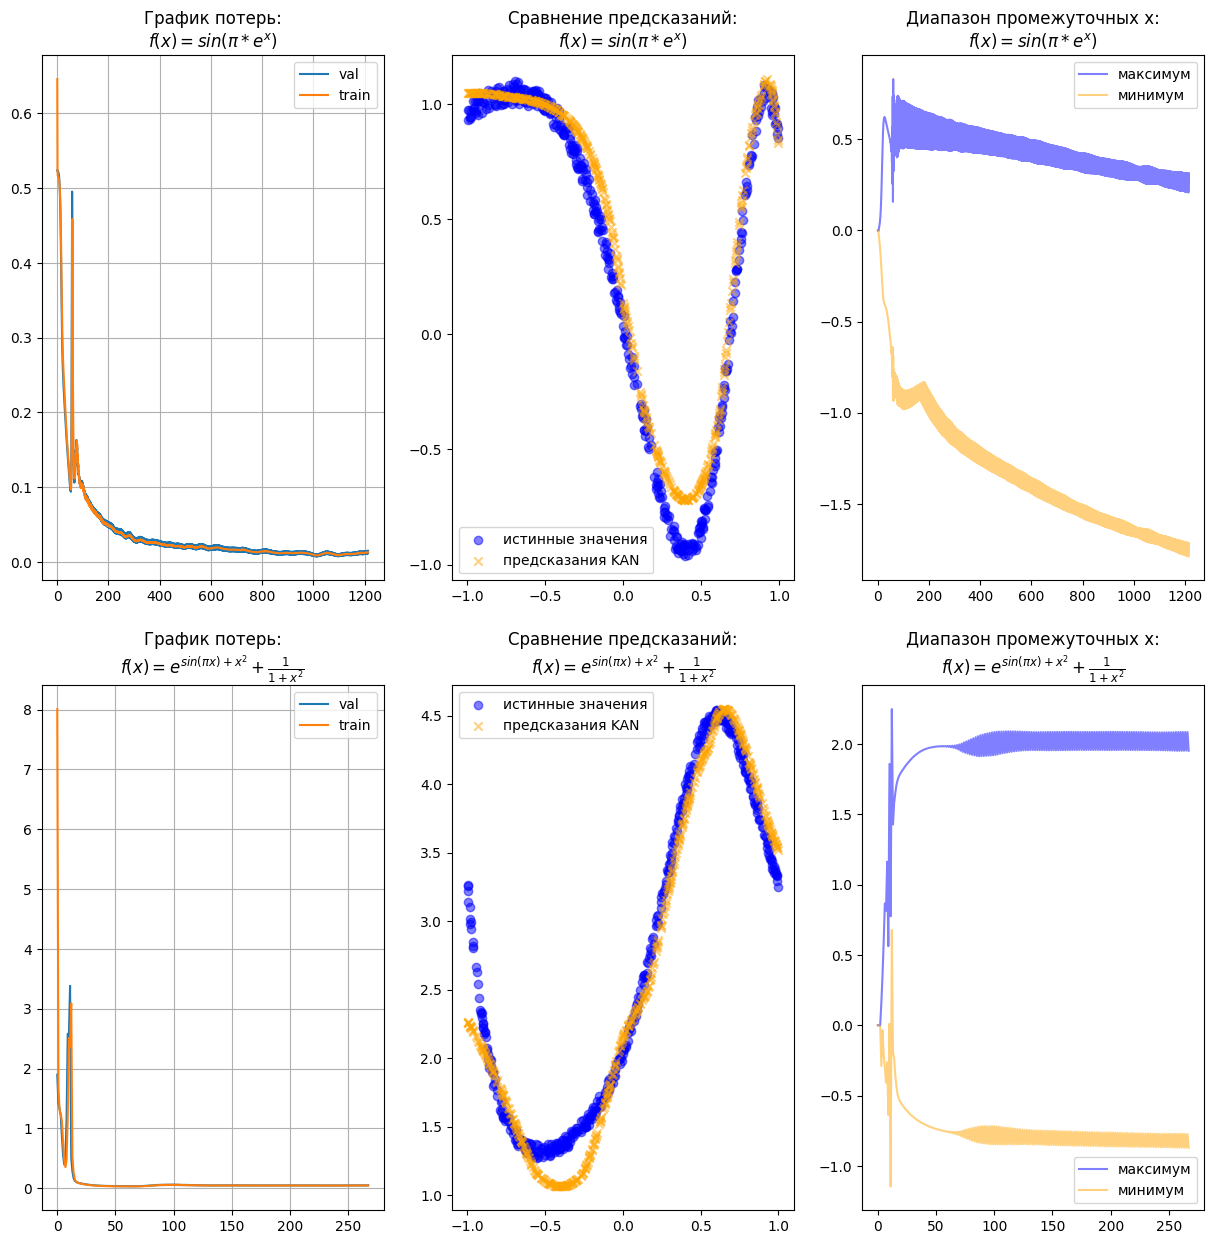

In [18]:
# Список функций, которые будем аппроксимировать с помощью KAN
fns = []

# Первая функция: f(x) = sin(π * e^x)
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

# Вторая функция: f(x) = e^(sin(πx) + x^2) + 1 / (1 + x^2)
fns += [(lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)), 
         '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]

# Гиперпараметры для обучения
lr = 0.1              # скорость обучения
k = 3                 # порядок B-сплайна
n_layers = 2          # количество слоев в сети KAN
grid_sizes = [3, 3]   # количество узлов (точек сетки) в каждом слое
grid_range = [-1, 1]  # диапазон значений x для сетки

# Создаем область для отрисовки графиков:
# - 2 функции (2 строки)
# - 3 графика для каждой функции (3 столбца)
fig, axs = plt.subplots(nrows=len(fns), ncols=3, figsize=(15, 15), dpi=100)

# Перебираем все функции по очереди
for idx, (fn, fn_label) in enumerate(fns):
    # Создаем диапазон x от -1 до 1 (999 точек)
    x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)

    # Вычисляем целевую функцию и добавляем немного случайного шума (0.1 * случайное число)
    y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

    # --- Разделение данных на обучающую и тестовую выборки ---
    n_training = int(x_eval.shape[0] * 0.8)  # 80% данных для обучения
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)  # случайные индексы для обучения
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]  # остальные — тестовые

    # Создаем обучающие и тестовые подмножества
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # Печатаем информацию о текущей функции и размерах выборки
    print(fn_label)
    print("Количество примеров в обучающей выборке: ", n_training)
    print("Количество примеров в тестовой выборке: ", len(test_idxs))

    # Обучаем модель KAN для данной функции
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training, y_training, x_test, y_test,
        lr=lr, k=k, n_layers=n_layers,
        grid_sizes=grid_sizes, verbose=False,
        grid_range=grid_range
    )

    # Печатаем среднюю ошибку по последним 100 итерациям
    print(f"{fn_label}\tСредняя ошибка (val): {np.mean(losses_kan['val'][-100:]): 0.5f}")

    # === Визуализация ===

    # (1) График потерь (обучение и проверка)
    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')    # ошибка на тесте
    ax.plot(losses_kan['train'], label='train')  # ошибка на обучении
    ax.grid()
    ax.set_title(f"График потерь:\n{fn_label}")
    ax.legend()

    # (2) График предсказаний модели против истинных значений
    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), 
               color='blue', alpha=0.5, label='истинные значения')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), 
               color='orange', alpha=0.5, label='предсказания KAN', marker='x')
    ax.legend()
    ax.set_title(f"Сравнение предсказаний:\n{fn_label}")

    # (3) График диапазона значений промежуточных слоев KAN
    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]  # минимальные значения по слоям
    x_max = [xs[0].max().item() for xs in all_xs]  # максимальные значения по слоям
    ax.plot(x_max, color='blue', alpha=0.5, label='максимум')
    ax.plot(x_min, color='orange', alpha=0.5, label='минимум')
    ax.legend()
    ax.set_title(f"Диапазон промежуточных x:\n{fn_label}")


Посмотрев на результаты приходим к выводу, что максимальное значение иногда превышает 1, выходя за пределы ожидаемой области, что иллюстрирует ситуацию, когда промежуточные значения иногда могут выходить за пределы предполагаемого диапазона. Для предотвращения такого случая, рассмотрим следующее решение.


### 2. Масштабирование функции активации для стабильности сети KAN

### 2. Масштабирование функции активации в KAN

В сети KAN выходы нейронов вычисляются через B-сплайны. Для контроля диапазона значений используют два метода:

1. **Расширение диапазона сетки**  
   Увеличивается диапазон узлов сплайна, например `Grid_range = [-2, 2]`, чтобы значения нейронов оставались в области определения базисов.

2. **Обучаемый коэффициент масштабирования**  
   Вводится параметр `w`, который масштабирует выход сплайна после добавления смещения $b(x)$:

$$
\phi(x) = w \cdot \Big(b(x) + \sum_{i=0}^{n} c_i \cdot N_i(x)\Big)
$$

где $c_i$ — коэффициенты B-сплайнов, $N_i(x)$ — значения базисов, $b(x)$ — смещение, $w$ — обучаемый коэффициент масштабирования.
Этот метод предпочтителен, так как даёт более надёжное решение.

Далее, будут рассмотрены два варианта с функцией:

$$
f(x) = e^{\sin(\pi x) + x^2} + \frac{1}{1+x^2}
$$


Начнем исследовать влияние масштабирования на качество аппроксимации функции. Сформируем набор данных и шум и поделим выборку на обучающую и тестовую.
Далее, создадим три конфигурации модели KAN:
1) Без масштабирования, с диапазоном сетки [-1, 1];
2) Без масштабирования, но с расширенным диапазоном [-2, 2];
3) С использованием масштабирования при диапазоне [-1, 1].

Каждая модель будет обучаться с одинаковыми параметрами скорости обучения, числа слоев и узлов. После обучения сравниваем результаты путем анализа графика функции потерь, точности аппроксимации и диапазона промежуточных значений.

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_23404\3254113578.py:4: SyntaxWarning: invalid escape sequence '\p'
  '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$'


Масштабирование: нет, Диапазон: [-1, 1]
Количество примеров в обучающей выборке: 799
Количество примеров в тестовой выборке: 446
Остановка: Нет дальнейших улучшений!
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Средняя ошибка (val):  0.00860
Масштабирование: нет, Диапазон: [-2, 2]
Количество примеров в обучающей выборке: 799
Количество примеров в тестовой выборке: 446
Остановка: Лимит итераций достигнут...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Средняя ошибка (val):  0.00559
Масштабирование: да, Диапазон: [-1, 1]
Количество примеров в обучающей выборке: 799
Количество примеров в тестовой выборке: 446
Остановка: Нет дальнейших улучшений!
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Средняя ошибка (val):  0.01351


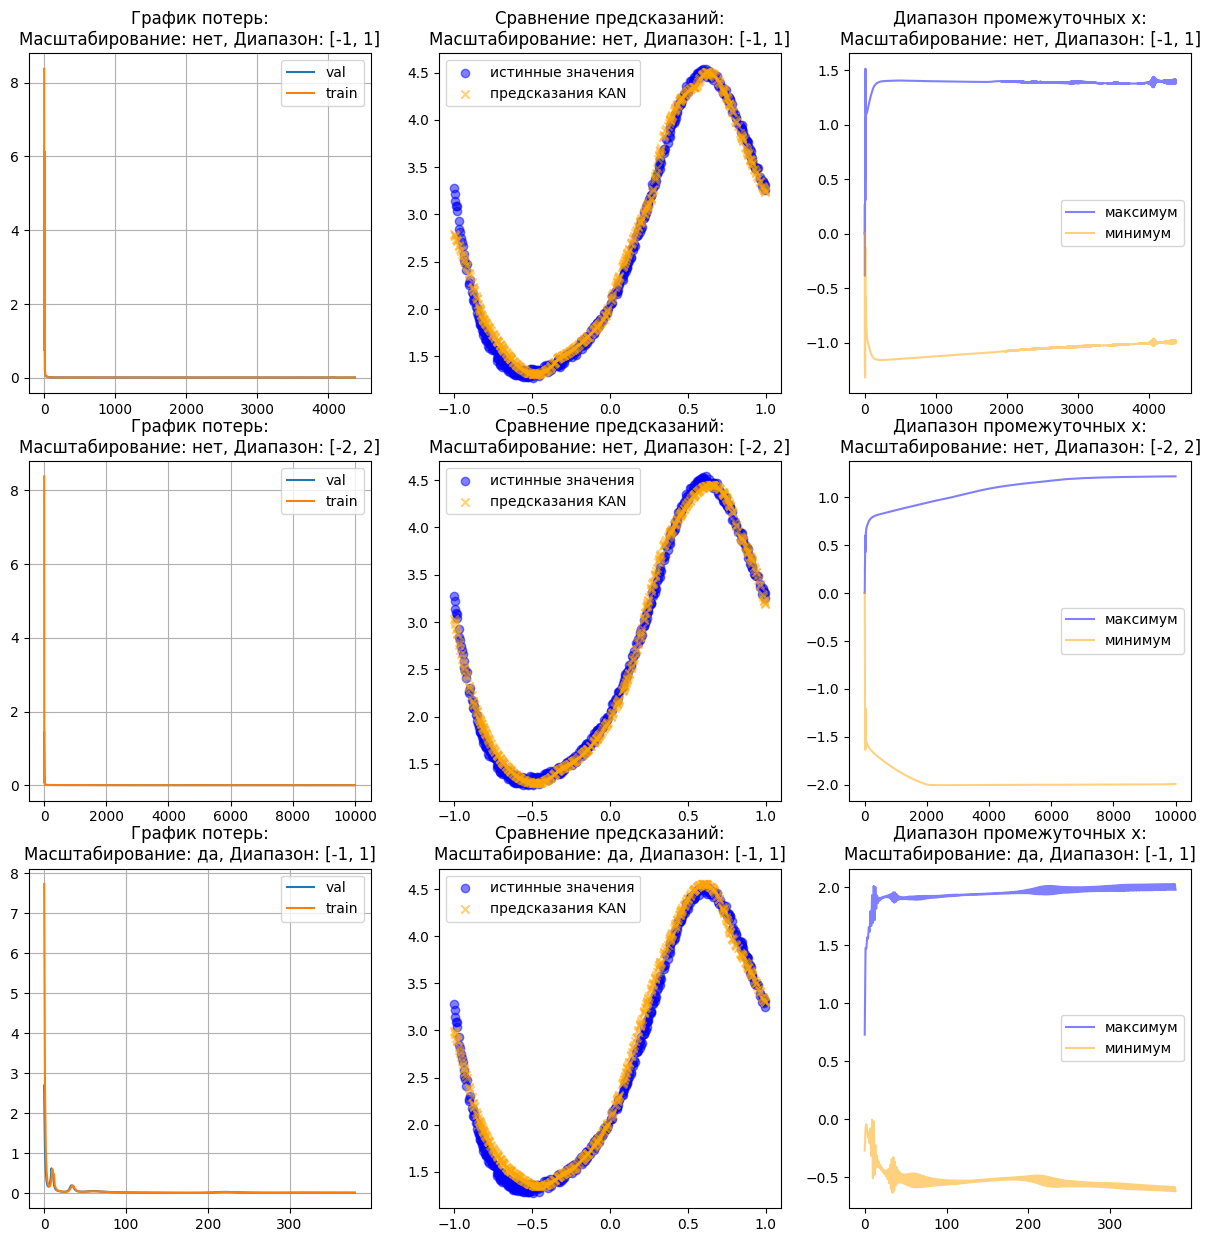

In [33]:
# Определяем функцию для аппроксимации и её подпись для вывода
fn, fn_label = (
    lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),
    '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$'
)

# Варианты использования масштабирования
use_scales = [True, False]

# Создаем 999 точек от -1 до 1 и вычисляем значения функции
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)  # Добавляем шум для реалистичности

# Разделяем данные на обучающую и тестовую выборки
n_training = int(x_eval.shape[0] * 0.8)  # 80% для обучения
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

# Задаем три сценария с разными параметрами сетки и масштабирования
params = [
    (dict(use_scales=False, grid_ranges=[[-1, 1], [-1, 1]]), 'Масштабирование: нет, Диапазон: [-1, 1]'),
    (dict(use_scales=False, grid_ranges=[[-1, 1], [-2, 2]]), 'Масштабирование: нет, Диапазон: [-2, 2]'),
    (dict(use_scales=True, grid_ranges=[[-1, 1], [-1, 1]]), 'Масштабирование: да, Диапазон: [-1, 1]'),
]

# Основные параметры модели
lr = 0.1          # скорость обучения
k = 3             # порядок сплайна
n_layers = 2      # количество слоев в сети
grid_sizes = [4, 4]  # количество узлов сетки для каждого слоя

# Подготовка фигуры для визуализации
fig, axs = plt.subplots(nrows=len(params), ncols=3, figsize=(15, 15), dpi=100)
final_losses = []

# Основной цикл по каждому набору параметров
for idx, param in enumerate(params):
    label = param[1]
    print(label)
    print("Количество примеров в обучающей выборке:", n_training)
    print("Количество примеров в тестовой выборке:", len(test_idxs))

    # Обучаем модель KAN с заданными параметрами
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training, y_training, x_test, y_test,
        lr=lr, k=k, n_layers=n_layers, grid_sizes=grid_sizes,
        verbose=False, **param[0]
    )

    # Выводим среднюю валидационную ошибку за последние 100 итераций
    print(f"{fn_label}\tСредняя ошибка (val): {np.mean(losses_kan['val'][-100:]): 0.5f}")
    final_losses.append((label, np.mean(losses_kan['val'][-100:])))

    # График потерь
    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')    # ошибка на тестовой выборке
    ax.plot(losses_kan['train'], label='train')  # ошибка на обучении
    ax.grid()
    ax.set_title(f"График потерь:\n{label}")
    ax.legend()

    # График предсказаний модели против истинных значений
    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(),
               color='blue', alpha=0.5, label='истинные значения')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(),
               color='orange', alpha=0.5, label='предсказания KAN', marker='x')
    ax.legend()
    ax.set_title(f"Сравнение предсказаний:\n{label}")

    # График диапазона значений промежуточных слоев KAN
    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]  # минимальные значения по слоям
    x_max = [xs[0].max().item() for xs in all_xs]  # максимальные значения по слоям
    ax.plot(x_max, color='blue', alpha=0.5, label='максимум')
    ax.plot(x_min, color='orange', alpha=0.5, label='минимум')
    ax.legend()
    ax.set_title(f"Диапазон промежуточных x:\n{label}")


In [22]:
for label, loss in final_losses:
    print(f"{label}: {loss: 0.5f}")

Масштабирование: нет, Диапазон: [-1, 1]:  0.00935
Масштабирование: нет, Диапазон: [-2, 2]:  0.00543
Масштабирование: да, Диапазон: [-1, 1]:  0.00506


Рассматривая результаты обучения модели KAN, видно, что при узком диапазоне сетки [-1, 1] без масштабирования промежуточные выходы и потери достигают больших значений, что делает обучение менее стабильным. Расширение диапазона сетки до [-2, 2] или включение обучаемых масштабов при диапазоне [-1, 1] заметно снижает потери и делает работу сети более предсказуемой.

Использование параметров масштабирования оказывается особенно полезным: они помогают контролировать диапазон значений промежуточных нейронов, предотвращают выход данных за пределы допустимого диапазона и делают процесс обучения более плавным.

### 3. Чем KAN отличается от MLP?

Теперь рассмотрим обучение MLP (многослойного перцептрона) сопоставимого размера и сравним его с KAN.

Для этого напишем функцию single_stacked_mlp_training для обучения MLP и создадим аналогичный предыдущему набор данных.
В функции обучения инициализируем веса и смещения всех слоев, применяем линейные преобразования с нелинейной активацией SiLU, вычисляем ошибку по MSE, выполняем градиентный спуск и реализуем раннюю остановку при отсутствии улучшений.

In [27]:
# Функция для обучения MLP сопоставимого размера
def single_stacked_mlp_training(x_training, y_training, x_test, y_test, lr, layer_sizes, 
                                early_stopping_imrpovement_threshold=200, early_stopping_iterations=1e4, verbose=True):
    """
    Обучить MLP (многослойный перцептрон) аналогичного размера.
    
    Параметры:
        x_training: обучающие входы
        y_training: обучающие цели
        x_test: тестовые входы
        y_test: тестовые цели
        lr: скорость обучения
        layer_sizes: список размеров скрытых слоев
        early_stopping_imrpovement_threshold: количество итераций без улучшения для остановки
        early_stopping_iterations: максимальное количество итераций
        verbose: печатать ли промежуточные результаты
    """
    
    # Формируем список всех слоев MLP (входной + скрытые + выходной)
    layer_sizes = [1] + layer_sizes + [1]
    weights, biases = [], []
    n_layers = len(layer_sizes)

    # Инициализируем веса и смещения для каждого слоя
    for idx in range(n_layers-1):
        w = torch.randn(layer_sizes[idx], layer_sizes[idx+1], requires_grad=True)  # случайные веса
        weights.append(w)
        b = torch.zeros(layer_sizes[idx+1], requires_grad=True)  # нулевые смещения
        biases.append(b)

    losses = {'train': [], 'val': []}  # словарь для хранения ошибок обучения и валидации
    best_loss = np.inf
    n_no_improvements = 0
    i = 0

    # Основной цикл обучения
    while True:
        x = x_eval  # входные данные
        for weight, bias in zip(weights, biases):
            x = F.linear(x, weight.t(), bias)  # линейное преобразование
            x = F.silu(x)  # нелинейная активация SiLU (можно было ReLU, но SiLU работает лучше)
        
        y_pred = x  # предсказанные значения
        loss = torch.mean(torch.pow(y_pred - y_target, 2))  # MSE
        loss.backward()  # вычисляем градиенты
        losses['train'].append(loss.item())

        # Шаг градиентного спуска
        for weight, bias in zip(weights, biases):
            weight.data = weight.data - lr * weight.grad
            weight.grad.zero_()
            bias.data = bias.data - lr * bias.grad
            bias.grad.zero_()

        # Вычисление ошибки на тестовой выборке
        with torch.no_grad():
            x = x_test
            for weight, bias in zip(weights, biases):
                x = F.linear(x, weight.t(), bias)
                x = F.silu(x)
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))
            losses['val'].append(val_loss.item())

        # Печать промежуточных результатов
        if i % 100 == 0 and verbose:
            print(f"Ошибка на валидации: {val_loss.item():0.5f}\tОшибка на обучении: {loss.item():0.5f}\tЛучший результат:{best_loss:0.5f}")
            
        # Проверка на лучшее значение
        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = [weights, biases]
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_imrpovement_threshold:
                print('Остановка: улучшений нет...')
                break
    
        i += 1
        if i > early_stopping_iterations:
            print('Остановка: достигнут лимит итераций...')
            break       

    return best_model, y_pred_test, losses


Теперь создадим набор данных по целевой функции $ f\left(x\right)=e^{sin\left(\pi x\right)+x^2}+\frac{1}{1+x^2} $ добавим небольшой шум и поделим данные на обучающую и тестовую выборки.

In [28]:
# Создаем набор данных для тестирования MLP
fn, fn_label = (
    lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),  # целевая функция
    '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$'
)

# Генерируем 999 точек от -1 до 1 и вычисляем значения функции с добавлением шума
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)  # добавляем шум

# --- Разделение на обучающую и тестовую выборки ---
n_training = int(x_eval.shape[0] * 0.8)  # 80% для обучения
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)  # случайные индексы для обучения
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]  # оставшиеся — тестовые

x_training = x_eval[training_idxs]  # обучающие входы
x_test = x_eval[test_idxs]          # тестовые входы
y_training = y_target[training_idxs]  # обучающие цели
y_test = y_target[test_idxs]          # тестовые цели

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_23404\2936648018.py:4: SyntaxWarning: invalid escape sequence '\p'
  '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$'


Обучим двухслойный KAN без использования масштабирования. В параметрах обучения также определяем размеры сеток и порядок B-сплайнов, затем вызываем функцию обучения single_stacked_kan_training и выводим информацию об обучении.

In [ ]:
# Обучение KAN [1, 1, 1]

use_scales = False           # Не использовать обучаемые параметры масштабирования
grid_sizes = [5, 5]          # Количество узлов сетки для каждого слоя
grid_ranges = []             # Диапазоны сетки не задаются, будут использоваться значения по умолчанию [-1, 1]
n_layers = 2                 # Количество слоёв сети KAN
lr = 0.1                     # Скорость обучения
k = 3                         # Порядок B-сплайна

# Вызов функции обучения KAN
params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
    x_training, y_training, x_test, y_test,
    lr=lr, k=k, n_layers=n_layers,
    grid_sizes=grid_sizes, verbose=False,
    grid_ranges=[], use_scales=use_scales
)

# Вывод общего количества параметров (коэффициентов) модели
print(f"Количество параметров: {sum([x.numel() for x in params_kan['coeffs']])}")

# Вывод средней ошибки на тестовой выборке за последние 100 итераций
print(f"Средняя ошибка: {np.mean(losses_kan['val'][-100:]): 0.5f}")


Остановка: Нет дальнейших улучшений!
Количество параметров: 14
Средняя ошибка:  0.02025


Обучаем MLP-сеть с двумя скрытыми слоями размером 3.

In [ ]:
# Обучение MLP (многослойного перцептрона)

lr = 0.1                     # Скорость обучения
layer_sizes = [3, 3]         # Размеры скрытых слоёв MLP

# Вызов функции обучения MLP
params_mlp, y_pred_mlp, losses_mlp = single_stacked_mlp_training(
    x_training, y_training, x_test, y_test,
    lr=lr, layer_sizes=layer_sizes, verbose=False
)

# Разделение обученных параметров на веса и смещения
weights, biases = params_mlp

# Вывод общего количества параметров сети
print(f"Количество обученных параметров: {sum([x.numel() for x in weights]) + sum([x.numel() for x in biases])}")

# Вывод средней ошибки на тестовой выборке за последние 100 итераций
print(f"Средняя ошибка (val): {np.mean(losses_mlp['val'][-100:]): 0.5f}")


Остановка: достигнут лимит итераций...
Количество обученных параметров: 22
Средняя ошибка (val):  0.01993


Визуализируем результаты предсказаний KAN и MLP на тестовой выборке и сравниваем их с истинными значениями.

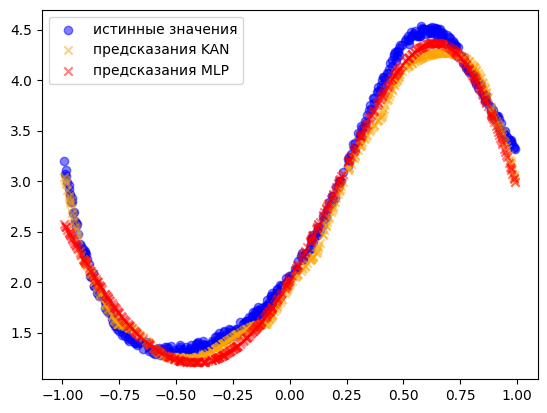

In [ ]:
# Визуализация предсказаний моделей

# Рисуем истинные значения (target) синим цветом
plt.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='истинные значения')

# Рисуем предсказания KAN оранжевым цветом с крестиком
plt.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='предсказания KAN', marker='x')

# Рисуем предсказания MLP красным цветом с крестиком
plt.scatter(x_test[:, 0].tolist(), y_pred_mlp[:, 0].tolist(), color='red', alpha=0.5, label='предсказания MLP', marker='x')

# Добавляем легенду для обозначения цветов и моделей
plt.legend()


MLP для того же количества параметров дает меньшие потери по сравнению с KAN аналогичного размера. Однако могут существовать некоторые гиперпараметры для обучения MLP, обеспечивающие аналогичную или лучшую производительность, чем KAN.

#### **Вывод**

В ходе работы изучены методы обучения коэффициентов в сетях KAN с использованием обратного распространения ошибки. Рассмотрены подходы к масштабированию функций активации на основе B-сплайнов и их влияние на стабильность и диапазон промежуточных значений нейронов. Проведена оценка и сравнение показателей KAN с показателями многослойного перцептрона (MLP), что позволило выявить особенности поведения сети KAN при аппроксимации сложных функций.
